In [1]:
! pip install torch

## Téléchargement et format des données

Nous avons un fichier a 7 colonnes

MOTS ---- POS ---- HEAD_ID ---- DEPREL ---- TARGET_OR_NOT ---- LABEL_ENCODE_1 ---- LABEL_ENCODE_2

---
Les 4 premières vous les connaissez déjà, elles ont été predites automatiquement avec un analyzeur syntaxique (UDPipe)

Les 3 dernières sont des colonnes associées à la semantique en frames (FrameNet)

**TARGET_OR_NOT**: indique si le mot peut déclancher une frame (T) ou pas (N)

**LABEL_ENCODE_1**: une façon de encoder les labels semantiques     [BIO] + [FE ou TG] + [ROLE or FRAME]

**LABEL_ENCODE_2**: une deuxième façon de encoder les labels semantiques     [BIO] + FRAME_NAME + [FE ou TG] + [ROLE or LEXICAL_UNIT]


---

Dans ce fichier il y a déjà eu un pretraitement pour selectioner quels sont les TARGET possibles. Si une phrase a 2 TARGETS ou plus elle a été dupliqué autant de fois qu'il y avait de TARGETS, pour pouvoir traiter un TARGET à la fois.



In [2]:
%%bash
if [ ! -f frames.data ]; then
    wget -q https://pageperso.lis-lab.fr/gabriel.marzinotto/frames.data
fi
head -20 frames.data

Même	ADV	2	advmod	N	O	O
si	SCONJ	7	mark	N	O	O
leur	DET	4	nmod:poss	N	B:FE:Product	B:Subjective_influence:FE:Product
culture	NOUN	7	nsubj:pass	N	I:FE:Product	I:Subjective_influence:FE:Product
a	AUX	7	aux	N	O	O
été	AUX	7	aux:pass	N	O	O
influencée	VERB	30	advcl	T	B:TG:Subjective_influence	B:Subjective_influence:TG:influencer
par	ADP	10	case	N	O	O
leurs	DET	10	nmod:poss	N	B:FE:Entity	B:Subjective_influence:FE:Entity
voisins	NOUN	7	obl	N	I:FE:Entity	I:Subjective_influence:FE:Entity
dans	ADP	14	case	N	B:FE:Domain	B:Subjective_influence:FE:Domain
de	DET	14	det	N	I:FE:Domain	I:Subjective_influence:FE:Domain
nombreux	ADJ	14	amod	N	I:FE:Domain	I:Subjective_influence:FE:Domain
domaines	NOUN	7	obl	N	I:FE:Domain	I:Subjective_influence:FE:Domain
(	PUNCT	16	punct	N	I:FE:Domain	I:Subjective_influence:FE:Domain
musique	NOUN	14	appos	N	I:FE:Domain	I:Subjective_influence:FE:Domain
,	PUNCT	18	punct	N	I:FE:Domain	I:Subjective_influence:FE:Domain
cuisine	NOUN	16	conj	N	I:FE:Domain	I:Subjective_influence:FE:

La première chose à faire est charger les données. Un premier tableau contiendra les mots de chaque phrase, et un second les POS, puis un pour TARGET_OR_NOT et pous de tableaux pour les étiquettes encodées.

In [3]:
list_text = []
list_pos = []
list_tg_or_not = []
list_labels_1 = []
list_labels_2 = []

with open('frames.data') as fp:
    text = []
    pos = []
    tg_tag = []
    label_1 = []
    label_2 = []
    
    for line in fp:
        tokens = line.strip().split('\t')
        #print(tokens)
        if len(tokens) > 1:
            text.append(tokens[0])
            pos.append(tokens[1])
            tg_tag.append(tokens[4])
            label_1.append(tokens[5])
            label_2.append(tokens[6])

        else:
            list_text.append(text)
            list_pos.append(pos)
            list_tg_or_not.append(tg_tag)
            list_labels_1.append(label_1)
            list_labels_2.append(label_2)

            text = []
            pos = []
            tg_tag = []
            label_1 = []
            label_2 = []

print(len(list_text))

print(list_text[12])
print(list_labels_1[12])

7605
['Les', 'débuts', 'de', 'la', 'néolithisation', 'de', '9500', 'à', '6000', 'av.']
['O', 'B:TG:Activity_start', 'B:FE:Activity', 'I:FE:Activity', 'I:FE:Activity', 'O', 'O', 'O', 'O', 'O']


Il faut ensuite convertir les étiquettes et les mots en entiers. Nous allons devoir créer des séquences de taille fixe, donc il faut réserver une étiquette de padding, ici `<eos>`. Toutefois, pour l'instant nous nous contentons de convertir les étiquettes sans appliquer le padding. Un defaultdict est utilisé pour créer le vocabulaire des étiquettes. À chaque fois qu'une nouvelle étiquette est rencontrée, il l'associe à une nouvelle valeur.

In [4]:
import collections
label_vocab = collections.defaultdict(lambda: len(label_vocab))
label_vocab['<eos>'] = 0

int_labels = []
for label in list_labels_1:
    int_labels.append([label_vocab[token] for token in label])

print(int_labels[12])
print(label_vocab)

[1, 11, 12, 13, 13, 1, 1, 1, 1, 1]
defaultdict(<function <lambda> at 0x7f4289307d08>, {'<eos>': 0, 'O': 1, 'B:FE:Product': 2, 'I:FE:Product': 3, 'B:TG:Subjective_influence': 4, 'B:FE:Entity': 5, 'I:FE:Entity': 6, 'B:FE:Domain': 7, 'I:FE:Domain': 8, 'B:FE:Cognizer': 9, 'I:FE:Cognizer': 10, 'B:TG:Activity_start': 11, 'B:FE:Activity': 12, 'I:FE:Activity': 13, 'B:FE:Co-timed_event': 14, 'I:FE:Co-timed_event': 15, 'B:FE:Time': 16, 'I:FE:Time': 17, 'B:TG:Killing': 18, 'B:FE:Victim': 19, 'B:TG:Origin': 20, 'B:FE:Instrument': 21, 'I:FE:Instrument': 22, 'B:TG:Using': 23, 'B:FE:Purpose': 24, 'I:FE:Purpose': 25, 'B:FE:Origin': 26, 'I:FE:Origin': 27, 'B:FE:Colonists': 28, 'I:FE:Colonists': 29, 'B:TG:Colonization': 30, 'B:FE:New_area': 31, 'I:FE:New_area': 32, 'B:FE:Sought_entity': 33, 'I:FE:Sought_entity': 34, 'B:TG:Locating': 35, 'B:TG:Scrutiny': 36, 'B:FE:Phenomenon': 37, 'I:FE:Phenomenon': 38, 'B:FE:Circumstances': 39, 'I:FE:Circumstances': 40, 'B:TG:Existence': 41, 'B:FE:Explanation': 42, 'I:F

Il en va de même pour les textes à qui nous allons dédier un vocabulaire différent de celui des étiquettes. Les embeddings préentraînés seront chargés à partir de ce vocabulaire. Il faut veiller à mettre les mots en minuscules car le vocabulaire des embeddings fasttext est en minuscules.

In [5]:
vocab = collections.defaultdict(lambda: len(vocab))
vocab['<eos>'] = 0

int_texts = []
for text in list_text:
    int_texts.append([vocab[token.lower()] for token in text])

print(int_texts[12])
len(vocab)

[23, 115, 12, 34, 116, 12, 117, 118, 119, 120]


18210

Egalement nous avons besoin de un input pour indiquer quel est la TARGET. Autrement, s'il y a plusieurs targets dans une phrase, le modèle ne pourrais pas faire la distinction.

In [6]:
tg_indicator_vocab = collections.defaultdict(lambda: len(tg_indicator_vocab))
tg_indicator_vocab['<eos>'] = 0

int_tg_indicator = []
for text in list_tg_or_not:
    int_tg_indicator.append([tg_indicator_vocab[token] for token in text])

print(int_tg_indicator[12])
len(tg_indicator_vocab)

[1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


3

In [7]:
pos_vocab = collections.defaultdict(lambda: len(pos_vocab))
pos_vocab['<eos>'] = 0

int_pos = []
for text in list_pos:
    int_pos.append([pos_vocab[token] for token in text])

print(int_pos[12])
len(pos_vocab)

[3, 4, 7, 3, 4, 7, 14, 7, 14, 7]


18

Nous pouvons maintenant créer des vocabulaires inversés pour pouvoir revenir vers les étiquettes et mots. Celà et utile pour vérifier le contenu d'un tenseur, et surtout pour convertir les décisions du système en étiquettes textuelles.

In [8]:
rev_label_vocab = {y: x for x, y in label_vocab.items()}
rev_vocab = {y: x for x, y in vocab.items()}

Nous pouvons maintenant calculer la longueur moyenne de nos exemples de apprentissage.
Ceci nous permettra définir une max_length pertinante pour apprendre notre resseaux
(Pas trop de padding)

In [9]:
! pip install matplotlib

(array([2.340e+03, 3.541e+03, 1.206e+03, 3.450e+02, 1.180e+02, 1.900e+01,
        1.300e+01, 1.700e+01, 3.000e+00, 3.000e+00]),
 array([  1. ,  21.8,  42.6,  63.4,  84.2, 105. , 125.8, 146.6, 167.4,
        188.2, 209. ]),
 <a list of 10 Patch objects>)

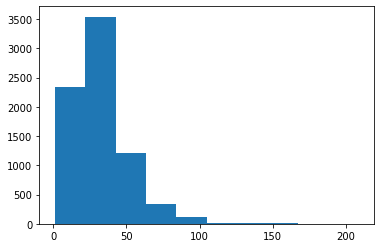

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

lengths = []
len_texts = [ len(text) for text in list_text ]

plt.hist(len_texts)

Importons les modules habituels de pytorch. Les constantes suivantes sont définies :

    max_len est la longueur maximale d'une phrase en apprentissage
    batch_size est la taille des batches
    embed_size est la taille des embeddings préentraînés (nous utiliserons les embeddings téléchargeables sur le site de fasttext qui sont de taille 300.
    hidden_size est la taille de l'état caché du RNN



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

max_len = 50
batch_size = 64
embed_size = 300
hidden_size = 128

Il faut maintenant créer des tenseurs pytorch avec les données phrases et les étiquettes associées. X et Y sont des tenseurs d'entiers de taille (le nombre d'exemples du corpus, la longueur maximale d'une phrase). Ils sont initialisés à zéro car c'est la valeur de padding.

Pour chaque phrase et séquence d'étiquettes associées, nous calculons la longueur effective à intégrer en fonction de la longueur maximale (les phrases et séquences d'étiquettes trop longues sont coupées). Puis nous pouvons les intégrer dans les tenseurs en début de ligne, les fins de lignes étant remplies de zéros (`<eos>`).


In [12]:
X = torch.zeros(len(int_texts), max_len).long()
T = torch.zeros(len(int_texts), max_len).long()
P = torch.zeros(len(int_texts), max_len).long()
Y = torch.zeros(len(int_labels), max_len).long()

for i, (text, tg, pos, label) in enumerate(zip(int_texts, int_tg_indicator, int_pos, int_labels)):
    length = min(max_len, len(text))
    X[i,:length] = torch.LongTensor(text[:length])
    T[i,:length] = torch.LongTensor(tg[:length])
    P[i,:length] = torch.LongTensor(pos[:length])
    Y[i,:length] = torch.LongTensor(label[:length])

print(X[12])
print(T[12])
print(P[12])
print(Y[12])

tensor([ 23, 115,  12,  34, 116,  12, 117, 118, 119, 120,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])
tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
tensor([ 3,  4,  7,  3,  4,  7, 14,  7, 14,  7,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([ 1, 11, 12, 13, 13,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


Pour vérifier les performances du système, nous le séparons en un ensemble d'entraînement et un ensemble de développement. Comme il y a 7605 exemple, nous utiliserons les 6000 premiers pour l'entraînement et les 1605 suivants pour la validation.



In [13]:
X_train = X[:6000]
T_train = T[:6000]
P_train = P[:6000]
Y_train = Y[:6000]

X_valid = X[6000:]
T_valid = T[6000:]
P_valid = P[6000:]
Y_valid = Y[6000:]

Torch contient des classes permettant facilement de charger des batches d'exemples déjà mélangés pour l'entraînement. Nous allons en tirer parti.


In [14]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, T_train, P_train, Y_train)
valid_set = TensorDataset(X_valid, T_valid, P_valid, Y_valid)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

La prochaine étape consiste en le chargement des embeddings préentraînés. Les embeddings fasttext peuvent être téléchargés depuis la page suivante : 

https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

Toutefois, ces embeddings couvrant plusieurs millions de mots, le fichier fait plusieurs GiB et une version filtrée par rapport au vocabulaire du corpus est disponible.


In [15]:
![ -f wiki.fr.vec.small ] || wget -q http://pageperso.lif.univ-mrs.fr/gabriel.marzinotto/wiki.fr.vec.small 

Les embeddings ont le format suivant :

    chaque ligne décrit l'embedding d'un mot
    le mot est sur la première colone, suivi des valeurs du vecteur dans l'espace de 300 dimension.

Nous créons donc un tenseur à zéro, puis plaçons l'embedding de chaque mot du vocabulaire rencontré à la bonne ligne dans le tenseur. Les embeddings des mots non couverts dans ce fichier resteront à zéro.


In [16]:
pretrained_weights = torch.zeros(len(vocab), 300)
with open('wiki.fr.vec.small') as fp:
    for line in fp:
        tokens = line.strip().split()
        if tokens[0] in vocab:
            try:
              pretrained_weights[vocab[tokens[0]]] = torch.FloatTensor([float(x) for x in tokens[1:]])
            except:
              continue
                
pretrained_weights[12][:10]

tensor([-0.0988, -0.1492, -0.0365,  0.0521,  0.2108, -0.0527,  0.0233,  0.0760,
         0.1252,  0.2180])

Le modèle est une class qui étend nn.Module. Son constructeur appelle le constructeur de la class mère, puis déclare les différentes couches : une couche d'embeddings, une couche de GRU et une couche de décision. Cette couche de décision sera appliquée à chaque position de la phrase pour prédire l'étiquette associée.

Le premier détail important que nous allons traiter est le problème du padding. Pour pouvoir prendre en entrée des batches de phrases de la même taille, nous avons complété ces dernières avec des 0. Le mot d'indice zéro a un embedding et le système peut donc l'utiliser pour apprendre des régularités des données. Si on utilise un RNN bidirectionnel, l'état caché après chaque padding peut aussi contribuer à la représentation créée. Ces deux problème font que le modèle aura un comportement différent si on change la taille des séquences traitées.

Une solution est de forcer l'état caché à rester à zéro en présence de padding. Pour celà il faut spécifier le padding_idx de la couche d'emebdding pour la représentation associée au padding soit toujours le vecteur nul. Ensuite, dans le RNN, l'état caché est calculé comme une transformation affine à partir de l'embedding en entrée et de l'état caché précédent. Comme l'état caché initial est à zéro, et que l'embedding du padding est à zéro, si on désactive le bias dans les calculs (en donnant l'option bias=False au GRU), cela va forcer l'état caché à rester à zéro tout au long du padding. Le modèle peut ainsi traiter des séquences de taille arbitraire, même quand il est bidirectionnel.

Le deuxième détail est l'initialisation des embeddings. La méthode diffère selon les versions de pytorch, mais la façon présentée ici marche dans la plupart des cas. Nous allons directement modifier le champ weight de la couche d'embeddings et remplacer ce paramètre par nos embeddings préentraînés. requires_grad=False permet de geler la couche d'embeddings et donc de ne pas les modifier lors de l'apprentissage. Cela permettra en prédiction d'utiliser des embeddings fasttext pour les mots que nous n'avons pas observés dans le corpus d'apprentissage, en espérant qu'un mot d'embedding proche s'y trouvait. Si on omet cette option, les embeddings sont fine-tunés pour maximiser les performances du système.


In [17]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.word_embed = nn.Embedding(len(vocab), embed_size, padding_idx=vocab['<eos>'])
        self.word_embed.weight = nn.Parameter(pretrained_weights, requires_grad=False)
        
        #Initialize the embeddings for the TARGET_OR_NOT using the identity matrix
        tg_ind = len(tg_indicator_vocab)
        self.tg_embed = nn.Embedding(tg_ind, tg_ind, padding_idx=tg_indicator_vocab['<eos>'])
        self.tg_embed.weight = nn.Parameter(torch.eye(tg_ind), requires_grad=False)
        
        self.rnn = nn.GRU(embed_size+tg_ind, hidden_size, bias=False, num_layers=1, dropout=0.3, bidirectional=False, batch_first=True)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(label_vocab))
        
    def forward(self, x, t):
        word_embed = self.word_embed(x)
        tg_embed = self.tg_embed(t)
        
        embed = torch.cat((word_embed,tg_embed),-1)
        
        output, hidden = self.rnn(embed)
        return self.decision(output)

rnn_model = RNN()
rnn_model

rnn_model(Variable(X[:2]), Variable(T[:2])).size()

/home/gabriel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


torch.Size([2, 50, 340])

La fonction qui calcule les performances d'un modèle doit accomoder la nouvelle forme des données.
En particulier, le critère d'entropie croisée n'accepte que des matrices à deux dimensions, donc il faut redimentionner les scores produits pour qu'ils ait la taille `(batch_size * sequence_length, num_labels)` et les références pour quelles aient la taille `(batch_size * sequence_length)`.

Ensuite, il faut modifier le max qui calcule les prédictions pour qu'il agisse sur la dernière dimension du tenseur `y_scores`.

Et finalement, pour calculer le score d'une séquence, nous devons ignorer le padding. Pour celà une matrice `mask` est crée qui contient 1 pour les éléments non nuls de la matrice contenant les étiquettes et 0 sinon.
On peut calculer le nombre de corrects ainsi que le numérateur de la fonction de performance en appliquant le masque.

Le loss, pour être comparable au loss de l'entraînement, n'est pas modifié.

In [18]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num_loss = num_perf = 0
    for x, t, p, y in loader:
        y_scores = model(Variable(x, volatile=True), Variable(t, volatile=True))
        loss = criterion( y_scores.view(y.size(0) * y.size(1), -1), 
                          Variable(y.view(y.size(0) * y.size(1)), volatile=True) )
        y_pred = torch.max(y_scores, 2)[1]
        mask = (y != 0)
        correct += torch.sum((y_pred.data == y) * mask)
        total_loss += loss.data
        num_loss += len(y)
        num_perf += torch.sum(mask)
        
    #print("df", correct, num_perf)
    return total_loss / num_loss, float(correct) / float(num_perf)

perf(rnn_model, valid_loader)

/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


(tensor(0.0936), 0.0010965732087227413)

La fonction d'apprentissage est modifiée en deux endroits. Tout d'abord, pytorch refuse d'entraîner un modèle contenant des paramètres sans gradient. Nous devons donc filtrer la liste des paramètres passés à l'optimiseur pour qu'elle ne contienne pas les embeddings "gelés".

Ensuite, nous appliquons le même redimenssionnement des scores et des équeittes pour accomoder le critère d'apprentissage.


In [19]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda param: param.requires_grad, model.parameters()))
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, t, p, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(Variable(x), Variable(t))
            loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), Variable(y.view(y.size(0) * y.size(1)), volatile=True))
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            num += len(y)
        print(epoch, total_loss / num, perf(model, valid_loader))

fit(rnn_model, 20)

/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


0 tensor(0.0334) (tensor(0.0191), 0.6725482866043614)
1 tensor(0.0203) (tensor(0.0182), 0.6747663551401869)
2 tensor(0.0194) (tensor(0.0175), 0.6756884735202492)
3 tensor(0.0183) (tensor(0.0163), 0.6779314641744548)
4 tensor(0.0170) (tensor(0.0153), 0.6891214953271028)
5 tensor(0.0159) (tensor(0.0148), 0.6973707165109034)
6 tensor(0.0151) (tensor(0.0140), 0.7037507788161994)
7 tensor(0.0144) (tensor(0.0137), 0.7057943925233645)
8 tensor(0.0136) (tensor(0.0130), 0.7137943925233645)
9 tensor(0.0130) (tensor(0.0125), 0.7171588785046729)
10 tensor(0.0124) (tensor(0.0122), 0.7210716510903427)
11 tensor(0.0119) (tensor(0.0118), 0.7247850467289719)
12 tensor(0.0114) (tensor(0.0115), 0.7283738317757009)
13 tensor(0.0110) (tensor(0.0113), 0.7331339563862929)
14 tensor(0.0106) (tensor(0.0111), 0.7358753894080997)
15 tensor(0.0102) (tensor(0.0109), 0.7348785046728972)
16 tensor(0.0099) (tensor(0.0107), 0.7382928348909658)
17 tensor(0.0095) (tensor(0.0106), 0.7416074766355141)
18 tensor(0.0092) (t

Une fois le modèle entraîné, nous pouvons écrire une fonction qui génère les prédictions pour une phrase. Cette fonction devra :

    convertir les mots en entiers (nous n'avons pas prévu de symbole pour les mots inconnus donc ils seront remplacés par du padding)
    faire un batch de taille 1 sous la forme d'un tenseur de dimensions (1, longueur de la phrase)
    calculer les scores des étiquettes à chaque position
    calculer les prédictions correspondantes
    et convertir les entiers prédits en text grâce au dictionnaire inversé créé plus haut

Notez que cette fonction peut prendre en entrée des phrases plus longues que max_len et que le temps de calcul n'est pas gaspillé par le padding.


## Viterbi Decoding
L'idée est de pouvoir appliquer certains contraintes sur les sorties.


In [20]:
import numpy

def get_transition_params(label_strs):
  '''Construct transtion scoresd (0 for allowed, -inf for invalid).
  Args:
    label_strs: A [num_tags,] sequence of BIO-tags.
  Returns:
    A [num_tags, num_tags] matrix of transition scores.  
  '''
  num_tags = len(label_strs)
  transition_params = numpy.zeros([num_tags, num_tags], dtype=numpy.float32)
  for i, prev_label in enumerate(label_strs):
    for j, label in enumerate(label_strs):
      if i != j and label[0] == 'I' and not prev_label == 'B' + label[1:]:
        transition_params[i,j] = numpy.NINF
  return torch.tensor(transition_params)



label_strs = [ rev_label_vocab[i] for i in range(len(rev_label_vocab)) ]
transition_params = get_transition_params(label_strs)


print(transition_params.shape)
#check the transition penalities from B:FE:Product for 15 labels
print(label_strs[0:14])
print(transition_params[2,0:14]) 

torch.Size([340, 340])
['<eos>', 'O', 'B:FE:Product', 'I:FE:Product', 'B:TG:Subjective_influence', 'B:FE:Entity', 'I:FE:Entity', 'B:FE:Domain', 'I:FE:Domain', 'B:FE:Cognizer', 'I:FE:Cognizer', 'B:TG:Activity_start', 'B:FE:Activity', 'I:FE:Activity']
tensor([0., 0., 0., 0., 0., 0., -inf, 0., -inf, 0., -inf, 0., 0., -inf])


In [21]:
import torch.nn.functional as F

def viterbi_decode(score, transition_params):
  """ Adapted from Tensorflow implementation.
  Decode the highest scoring sequence of tags outside of TensorFlow.
  This should only be used at test time.
  Args:
    score: A [seq_len, num_tags] matrix of unary potentials.
    transition_params: A [num_tags, num_tags] matrix of binary potentials.
  Returns:
    viterbi: A [seq_len] list of integers containing the highest scoring tag
        indicies.
    viterbi_score: A float containing the score for the Viterbi sequence.
  """
  trellis = torch.zeros_like(score)
  backpointers = torch.zeros_like(score)
  trellis[0] = score[0]
  for t in range(1, score.shape[0]):
    v = trellis[t - 1].unsqueeze(1) + transition_params
    trellis[t] = score[t] + torch.max(v, 0)[0]
    backpointers[t] = torch.argmax(v, 0)
  viterbi = [torch.argmax(trellis[-1]).long().view(1)]
  for bp in reversed(backpointers[1:]):
    viterbi.append(bp[viterbi[-1]].long().view(1))
  viterbi.reverse()
  viterbi = torch.cat(viterbi,0)
  viterbi_score, index = torch.max(trellis[-1],-1)
  
  return viterbi, viterbi_score

# we will use rev_label_vocab to go from ids -> labels
def fscore(model, loader, viterbi=None):
  
    def build_arg_matrix(y_tensor):
        refs = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict()) )
        nb_refs = 0.0
        
        batch_size, length = y_tensor.shape

        for i_ in range(batch_size):
          y_sent = y_tensor[i_,:]
          start_elem = None
          end_elem   = None
          label_elem = None

          for j,y in enumerate(y_sent):
  
            label = rev_label_vocab[y]
            # if padding...
            if(y == '<eos>'): 
              if( start_elem and end_elem and label_elem):
                refs[i_][start_elem][end_elem] = label_elem
                nb_refs += 1

              start_elem = None
              end_elem   = None
              label_elem = None
            
            
            elif(label[0] == "B"):
              
              if( start_elem and end_elem and label_elem):
                refs[i_][start_elem][end_elem] = label_elem
                nb_refs += 1
                
              start_elem = j
              end_elem   = j
              label_elem = label[2:]
              
              
            elif(label[0] == "I"):
                if(label[2:] == label_elem):
                  end_elem = j
                else:
                  if( start_elem and end_elem and label_elem):
                    refs[i_][start_elem][end_elem] = label_elem   
                    nb_refs += 1
              
                  start_elem = j
                  end_elem   = j
                  label_elem = label[2:]              
                              
            elif(label[0] == "O"):              
              if( start_elem and end_elem and label_elem):
                refs[i_][start_elem][end_elem] = label_elem
                nb_refs += 1

              start_elem = None
              end_elem   = None
              label_elem = None
          
          
          if( start_elem and end_elem and label_elem):
            refs[i_][start_elem][end_elem] = label_elem
            nb_refs += 1

        return refs, nb_refs
  
  
    def compare(y_true, y_pred):
        refs, nb_refs = build_arg_matrix(y_true.numpy())
        hyps, nb_hyps = build_arg_matrix(y_pred.numpy())
                
        nb_ok   = 0.0
        counter = 0
        for i, dico in refs.items():
          for j, subdico in dico.items():
            for k, value in subdico.items():   
              if( i in hyps and
                  j in hyps[i] and 
                  k in hyps[i][j] and
                  hyps[i][j][k] == value ):
                nb_ok += 1.0   
              
        return nb_ok, nb_refs, nb_hyps

    nb_ok = nb_ref = nb_hyp = 0
    model.eval()
    
    with torch.no_grad():
      for x, t, p, y in loader:
        y_scores = model(Variable(x, volatile=True), Variable(t, volatile=True))
        
        if(viterbi is not None):
          bs, tm, _ = y_scores.shape
          y_pred = torch.zeros((bs, tm))
          for i, y_score in enumerate(y_scores):
            y_score = torch.log( F.softmax(y_score) )
            a_pred, _ = viterbi_decode(y_score, viterbi)
            y_pred[i] = a_pred
        else:
          y_pred = torch.max(y_scores, 2)[1]

        k, r, h = compare(y, y_pred)
        nb_ok  += k
        nb_ref += r
        nb_hyp += h
    
    prec = nb_ok/nb_hyp
    recall = nb_ok/nb_ref
    f1 = 2*(prec*recall)/(prec+recall)
    
    return prec, recall, f1

print( fscore(rnn_model, valid_loader) )
print( fscore(rnn_model, valid_loader, viterbi=transition_params) )

/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(0.44782499371385465, 0.4317575757575758, 0.4396445322142681)


/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(0.6385916465308941, 0.4484848484848485, 0.5269154087154657)


In [22]:

def get_transition_params_from_data(label_strs, y_train):
  '''Construct transtion scoresd (0 for allowed, -inf for invalid).
  Args:
    label_strs: A [num_tags,] sequence of BIO-tags.
  Returns:
    A [num_tags, num_tags] matrix of transition scores.  
  '''
  num_tags = len(label_strs)
  transition_params = numpy.zeros([num_tags, num_tags], dtype=numpy.float32) 
  for i, prev_label in enumerate(label_strs):
    for j, label in enumerate(label_strs):
      if i != j and label[0] == 'I' and not prev_label == 'B' + label[1:]:
        transition_params[i,j] = numpy.NINF
  
  transition_counts = numpy.zeros([num_tags, num_tags], dtype=numpy.float32) + 0.1
  for seq in y_train:
    for i in range(len(seq)-1):
      prev_label = seq[i]
      next_lavel = seq[i+1]
      transition_counts[prev_label,next_lavel] += 1
      
  row_sums = transition_counts.sum(axis=1, keepdims=True)
  loglikelihoods = numpy.log( transition_counts  / row_sums )
  
  transition_params = transition_params + loglikelihoods
  
  return torch.tensor(transition_params)



label_strs = [ rev_label_vocab[i] for i in range(len(rev_label_vocab)) ]
transition_params = get_transition_params_from_data(label_strs, Y_train)


print(transition_params.shape)
#check the transition penalities from B:FE:Product for 15 labels
for l,c in zip( label_strs[0:14], transition_params[2,0:14] ):
  print(l,c)

print( fscore(rnn_model, valid_loader, viterbi=transition_params) )

torch.Size([340, 340])
<eos> tensor(-6.2729)
O tensor(-6.2729)
B:FE:Product tensor(-6.2729)
I:FE:Product tensor(-1.0206)
B:TG:Subjective_influence tensor(-6.2729)
B:FE:Entity tensor(-6.2729)
I:FE:Entity tensor(-inf)
B:FE:Domain tensor(-6.2729)
I:FE:Domain tensor(-inf)
B:FE:Cognizer tensor(-6.2729)
I:FE:Cognizer tensor(-inf)
B:TG:Activity_start tensor(-6.2729)
B:FE:Activity tensor(-6.2729)
I:FE:Activity tensor(-inf)


/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(0.7503401360544217, 0.2673939393939394, 0.3942806076854334)


##RNN-CRF
Nous avons la possibilité de faire un modèle CRF sur les features calculés par notre RNN

In [23]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

  
class RNN_CRF(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.word_embed = nn.Embedding(len(vocab), embed_size, padding_idx=vocab['<eos>'])
        self.word_embed.weight = nn.Parameter(pretrained_weights, requires_grad=False)
        
        #Initialize the embeddings for the TARGET_OR_NOT using the identity matrix
        tg_ind = len(tg_indicator_vocab)
        self.tg_embed = nn.Embedding(tg_ind, tg_ind, padding_idx=tg_indicator_vocab['<eos>'])
        self.tg_embed.weight = nn.Parameter(torch.eye(tg_ind), requires_grad=False)
        
        self.tagset_size = len(label_vocab)
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        
        self.rnn = nn.GRU(embed_size + tg_ind, hidden_size, bias=False, num_layers=1, dropout=0.3, bidirectional=False, batch_first=True)
        self.decision_frame = nn.Linear(hidden_size * 1 * 1, len(label_vocab))
        

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.log(torch.full((1, self.tagset_size), 1.0/float(self.tagset_size)))
        end_vvars   = torch.log(torch.full((1, self.tagset_size), 1.0/float(self.tagset_size)))

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + end_vvars
        alpha = log_sum_exp(terminal_var)
        return alpha

      
    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        
        for i, feat in enumerate(feats[0:-1]):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        #score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score
      
      
    def _viterbi_decode(self, feats):
        
        all_scores   = []
        all_bestpath = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.log(torch.full((1, self.tagset_size), 1.0/float(self.tagset_size)))
        end_vvars  = torch.log(torch.full((1, self.tagset_size), 1.0/float(self.tagset_size)))
        
        # forward_var at step i holds the viterbi variables for step i-1
        for batch_elem in feats: 
            backpointers = []
            forward_var = init_vvars
            for feat in batch_elem:
                bptrs_t = []  # holds the backpointers for this step
                viterbivars_t = []  # holds the viterbi variables for this step
                #print("feat",feat.shape)
                for next_tag in range(self.tagset_size):
                    # next_tag_var[i] holds the viterbi variable for tag i at the
                    # previous step, plus the score of transitioning
                    # from tag i to next_tag.
                    # We don't include the emission scores here because the max
                    # does not depend on them (we add them in below)
                    #print(next_tag, forward_var.shape, self.transitions.shape, self.transitions[next_tag].shape )
                    next_tag_var = forward_var + self.transitions[next_tag]
                    best_tag_id = argmax(next_tag_var)
                    bptrs_t.append(best_tag_id)
                    viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
                # Now add in the emission scores, and assign forward_var to the set
                # of viterbi variables we just computed
                forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
                backpointers.append(bptrs_t)

            # Transition to STOP_TAG
            terminal_var = forward_var  #+ self.transitions[self.tag_to_ix[STOP_TAG]] #+ end_vvars
            best_tag_id = argmax(terminal_var)
            path_score = terminal_var[0][best_tag_id]

            # Follow the back pointers to decode the best path.
            best_path = [best_tag_id]
            for bptrs_t in reversed(backpointers):
                best_tag_id = bptrs_t[best_tag_id]
                best_path.append(best_tag_id)

            best_path.reverse()
            all_scores.append(path_score)
            all_bestpath.append(best_path)
            
        return all_scores, all_bestpath        

    def neg_log_likelihood(self, x, t, y):
        feats = self._get_lstm_features(x, t)
        forward_score = self._forward_alg(feats[0])
        gold_score = self._score_sentence(feats[0], y[0])
        return forward_score - gold_score

      
   
    def _get_lstm_features(self, x, t):
        word_embed = self.word_embed(x)
        tg_embed = self.tg_embed(t)
        
        embed = torch.cat((word_embed,tg_embed),-1)
        output, hidden = self.rnn(embed)

        frame_scores = self.decision_frame(output)
        return frame_scores
   
      
    def forward(self, x, t):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        frame_scores = self._get_lstm_features(x, t)      
        
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(frame_scores)
        
        return score, tag_seq
      
      
rnn_crf_model = RNN_CRF()
rnn_crf_model

a, b = rnn_crf_model(Variable(X[:2]), Variable(T[:2]))
print(a)
print(b)

[tensor(159.4783, grad_fn=<SelectBackward>), tensor(159.4845, grad_fn=<SelectBackward>)]
[[138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138], [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]]


In [24]:
def fit_crf(model, epochs):
  
    optimizer = optim.Adam(filter(lambda param: param.requires_grad, model.parameters()))
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, t, p, y in train_loader:
            optimizer.zero_grad()
            loss = model.neg_log_likelihood(x, t, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            num += len(y)
        print(epoch, total_loss / num )

fit_crf(rnn_crf_model, 20)




KeyboardInterrupt: 